# Run inference on RDU

In this example you run inference on RDU using the LeNet model.
You generate predictions and then visualize them.
The images and prediction labels files use the same format as the MNIST files.

You randomly choose images and their predicted labels from the dataset and visualize them.
Then you visually estimate the accuracy by inspecting the images and comparing to the predicted labels.

## Model parameters

First, define some parameters to use with the model.

* `data_dir`: where your dataset is stored
* `dataset_name`: the dataset name you are going to use for inference
* `results_dir`: where the prediction labels will be stored
* `inir_ckpt_path`: the checkpoint file that we created during training
* `batch_size`: batch size; should match the batch size in the PEF file
* `num_classes`: number of classes (categories); usually 10 for MNIST datasets
* `num_features`: number of pixels in the input images; usually 28x28 = 784
* `pef`: the PEF file that was compiled for this model; could be the same we used in training or compiled for inference only
* `mapping`: use `section` here
* `inference`: set to True (obviously)

In [2]:
params = {
    "data_dir": "/home/pavela/datasets/fashion-mnist",
    "dataset_name": "t10k",
    "results_dir": "/home/pavela/results/lenet/",
    "init_ckpt_path": "/home/pavela/checkpoints/lenet/checkpoints-b32/1875.pt",
    "batch_size": 32,
    "num_classes": 10,
    "num_features": 784,
    "pef": "/home/pavela/sambaflow-apps/starters/lenet/out/lenet-b32/lenet-b32.pef",
    "mapping": "section",
    "inference": True,
}

## Imports

Some necessary imports.

Note: sometimes you have to execute the cell below 2 or 3 times to eliminate the import errors.

In [15]:
import os
from pathlib import Path
from typing import Tuple, Optional, Callable, List
from sys import exit

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import sambaflow
from sambaflow import samba
from torch.utils.data.dataloader import DataLoader
from mnist_utils import CustomMNIST, write_labels
from sambaflow.samba.utils.utils import trace_graph
from sambaflow.logging import samba_logger

## Set the log level

In [16]:
# Set the log level
samba_logger.set_level('error')

## Define the model

Use the same model class that was used in training.

In [10]:
class LeNet(nn.Module):
    """
    LeNet model for MNIST classification.

    Attributes:
        state: Dictionary to hold model's completed_steps and completed_epochs.
        conv1, conv2: Convolutional layers.
        maxpool1, maxpool2: Max pooling layers.
        fc1, fc2, fc3: Fully connected layers.
        criterion: Loss function.
    """

    def __init__(self, num_classes: int) -> None:
        super(LeNet, self).__init__()
        self.state = {"completed_steps": 0, "completed_epochs": 0}

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            dilation=(1, 1),
            bias=False,
        )

        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            dilation=(1, 1),
            bias=False,
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, inputs, labels):
        """Defines the forward propagation step."""
        x = self.conv1(inputs).relu()
        x = self.maxpool1(x)
        x = self.conv2(x).relu()
        x = self.maxpool2(x)
        x = torch.reshape(x, [x.shape[0], -1])
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        out = self.fc3(x)
        loss = self.criterion(out, labels)
        return loss, out

## Prepare the model

The following functions prepare the model: they load the checkpoint that we created during training and trace the model's graph.

In [11]:
def load_checkpoint(model, optimizer, init_ckpt_path: str):
    """
    Loads a checkpoint from a file and initialize the model and optimizer.

    Args:
        model (object): The model to be loaded.
        optimizer (object): The optimizer to be loaded.
        init_ckpt_path (str): The path to the checkpoint file.

    Returns:
        None
    """
    print(f"Loading checkpoint from file {init_ckpt_path}")
    ckpt = torch.load(init_ckpt_path)
    if model:
        print("Loading model...")
        model.load_state_dict(ckpt["model"])
        model.state["completed_steps"] = ckpt["completed_steps"]
        model.state["completed_epochs"] = ckpt["completed_epochs"]
    if optimizer:
        print("Loading optimizer...")
        optimizer.load_state_dict(ckpt["optimizer"])


def get_inputs(params) -> Tuple[samba.SambaTensor, samba.SambaTensor]:
    """
    Creates input images and labels to set the model's shape for compilation.

    Args:
        params: A dictionary containing various parameters including 'batch_size' and 'num_classes'.

    Returns:
        A tuple of input images and labels.
    """
    images = samba.randn(params["batch_size"], 1, 28, 28, name="image", batch_dim=0)
    labels = samba.randint(
        params["num_classes"], (params["batch_size"],), name="label", batch_dim=0
    )
    return (images, labels)


def prepare(model: nn.Module, optimizer, params):
    """
    Prepares the model by loading a checkpoint and tracing the graph.

    Args:
        model (nn.Module): The model to prepare.
        optimizer: The optimizer for the model.
        params: A dictionary of parameters.

    Returns:
        None
    """

    # We need to load the checkpoint first and then trace the graph to sync the weights from CPU to RDU
    if params["init_ckpt_path"]:
        load_checkpoint(model, optimizer, params["init_ckpt_path"])
    else:
        return False

    inputs = get_inputs(params)

    trace_graph(model, inputs, optimizer, pef=params["pef"], mapping=params["mapping"])
    return True

## Create a custom dataset

Create a custom dataset using the PyTorch's Dataset class.
You can read more about that here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

The `CustomMNIST` class is described in the `mnist_utils.py` file and imported above.

In [12]:
def get_dataset(dataset_name: str, params):
    """Retrieves the specified dataset after applying necessary transformations.

    Args:
        dataset_name: The name of the dataset to retrieve.
        params: A dictionary containing various parameters including 'data_dir' and 'inference'.

    Returns:
        The requested dataset as a CustomMNIST object.
    """
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            # norm by mean and var
            transforms.Normalize((0.1307,), (0.3081,)),
            # Reshape image to 1x28x28
            lambda x: x.reshape((1, 28, 28)),
        ]
    )

    data_dir = Path(params["data_dir"])
    img_file = data_dir / (dataset_name + "-images-idx3-ubyte")
    if params["inference"]:  # if running for inference there's no labels file
        lbl_file = None
    else:
        lbl_file = data_dir / (dataset_name + "-labels-idx1-ubyte")
    dataset = CustomMNIST(img_file, lbl_file, transform=transform)

    return dataset

## Create the inference function 

This function runs inference on the RDU to predict image labels using our trained model.

In [13]:
def batch_predict(model, dataset_name: str, params):
    """
    Generates the predictions for a given model on a dataset.

    Args:
        model (object): The trained model to use for prediction.
        dataset_name (str): The name of the dataset to use for prediction.
        params (dict): Additional parameters for the prediction.

    Returns:
        None
    """
    if dataset_name is None:
        dataset_name = "inference"
    data_dir = Path(params["data_dir"])
    print(f"Using dataset: {data_dir / dataset_name}")
    dataset = get_dataset(dataset_name, params)

    loader = DataLoader(
        dataset, batch_size=params.get("batch_size", 32), drop_last=True, shuffle=False
    )

    predicted_labels = []
    for _, (images, labels) in enumerate(loader):
        sn_images = samba.from_torch_tensor(images, name="image", batch_dim=0)
        sn_labels = samba.from_torch_tensor(labels, name="label", batch_dim=0)

        loss, predictions = samba.session.run(
            input_tensors=[sn_images, sn_labels],
            output_tensors=model.output_tensors,
            section_types=["fwd"],
        )
        loss, predictions = samba.to_torch(loss), samba.to_torch(predictions)
        _, predicted_indices = torch.max(predictions, axis=1)

        predicted_labels += predicted_indices.tolist()

    return predicted_labels

## Run inference

In [14]:
# Reset the Samba session
samba.session.reset(params["pef"])
# Create the model for 10 output classes
model = LeNet(10)
# Copy the model to RDU
samba.from_torch_model_(model)
# The optimizer is set to None because we are running inference
optimizer = None
# We need a valid checkpoint to run inference
if prepare(model, optimizer, params):
    predicted_labels = batch_predict(model, params["dataset_name"], params)
else:
    print("No valid checkpoint has been provided. Can't run prediction.")

Loading checkpoint from file /home/pavela/checkpoints/lenet/checkpoints-b32/1875.pt
Loading model...
Using dataset: /home/pavela/datasets/fashion-mnist/t10k


## Save the predicted labels

Save the predicted labels in a file in the same format that MNIST uses to provide training labels.

In [31]:
results_dir = Path(params["results_dir"])
results_dir.mkdir(parents=True, exist_ok=True)
write_labels(predicted_labels, str(results_dir / "prediction-labels-idx1-ubyte"))

## Create a custom dataset with predicted labels

Read the images from our inference dataset and predicted labels from the file generated by the model.

In [42]:
data_dir = Path(params["data_dir"])
predict_images_file = data_dir / "t10k-images-idx3-ubyte"
predict_labels_file = results_dir / "prediction-labels-idx1-ubyte"

Create a custom PyTorch dataset using the inference images, predicted labels, and the `data_transform` function.

In [44]:
data_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=(0.1307,), std=(0.3081,))]
)

predict_dataset = CustomMNIST(
    predict_images_file, predict_labels_file, transform=data_transform
)

## Create a display function

In [34]:
import matplotlib.pyplot as plt


def plot_examples(images, labels, columns=5):  # by default set rows=1
    rows = len(images) // (columns)
    fig = plt.figure(figsize=(6.4, 2 * rows))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        if i < columns * rows:
            ax = fig.add_subplot(rows, columns, i + 1)
            ax.imshow(img.reshape(28, 28), cmap="gray")
            ax.set_xticks([])  # set empty label for x axis
            ax.set_yticks([])  # set empty label for y axis
            ax.set_title(lbl)
    plt.tight_layout()
    return fig

## Display the images and predicted labels

Pick several (`sample_size`) images and their predicted labels randomly and display them. We use the Fashion MNIST dataset labels here.

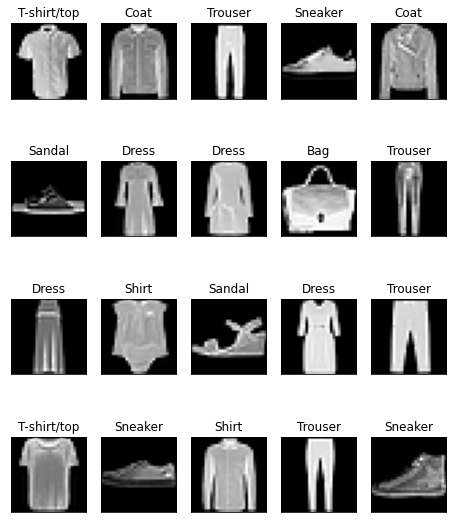

In [45]:
import random

images = []
labels = []
sample_size = 20

fashion_items = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

for i in range(0, sample_size):
    r = random.randint(0, len(predict_dataset))
    images.append(predict_dataset[r][0])
    labels.append(fashion_items[predict_dataset[r][1]])

plot_examples(images, labels, columns=5)
# keep the semicolon here or it will output the images twice